In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import tqdm
import glob
import urllib.request
%matplotlib inline



In [4]:
df = pd.read_csv('data.csv', header=None, names=["id", "image", "published", "disabled"])

df['available'] = 0

all_images_path = 'data/all_images'

for i, row in df.iterrows():
    file = os.path.join(all_images_path, row['id'] + '.jpg')
    if os.path.isfile(file):
        df.at[i, 'available'] = 1

        
df = df.loc[df.query('available == 1').index, :]
df = df.reset_index(drop=True)
df[:100]

,id,image,published,disabled,available
0,5e5836fee917e8d9a8a7b277,https://scontent.xx.fbcdn.net/v/t51.2885-15/87...,1,0,1
1,5e58343ded065ad79e312f3d,https://scontent.xx.fbcdn.net/v/t51.2885-15/85...,1,0,1
2,5e57dc939e88b6be2ac42800,https://scontent.xx.fbcdn.net/v/t51.2885-15/87...,1,0,1
3,5e55dca437fa5927dcdf02f3,https://scontent.xx.fbcdn.net/v/t51.2885-15/81...,1,0,1
4,5e55d69eb9e5b725cd7ba02f,https://scontent.xx.fbcdn.net/v/t51.2885-15/87...,1,0,1
...,...,...,...,...,...
95,5e4997d58c50694041d4b4ab,https://scontent.xx.fbcdn.net/v/t51.2885-15/81...,1,0,1
96,5e4997d58c50694041d4b4ad,https://scontent.xx.fbcdn.net/v/t51.2885-15/84...,1,0,1
97,5e498aebe3db753e479686e1,https://scontent.xx.fbcdn.net/v/t51.2885-15/85...,1,0,1
98,5e498aec293cba3e356ca9da,https://scontent.xx.fbcdn.net/v/t51.2885-15/82...,1,0,1


In [5]:

df[:50].to_csv('preprocess_data.txt', index=False, header=False)

In [3]:
import torchvision
import torch
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from torchvision import transforms
import tqdm
import pickle
from torchvision import models
%matplotlib inline


def get_pretrain_model():
    
    #return torchvision.models.vgg16(pretrained=True)
    
    arch = 'resnet50'
    # load the pre-trained weights
    model_file = '%s_places365.pth.tar' % arch
    if not os.access(model_file, os.W_OK):
        weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
        os.system('wget ' + weight_url)

    model = models.__dict__[arch](num_classes=365)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    return model

model = get_pretrain_model()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
feature_extraction_model = torch.nn.Sequential(*list(model.children())[:-1])

print(feature_extraction_model)

feature_extraction_model.eval()

out = feature_extraction_model(torch.zeros(1,3,224,224))
print(out.shape)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])


In [6]:
train_on_gpu = torch.cuda.is_available()

def extract_image_features(feature_extraction_model, df):
    feature_extraction_model.eval()
    
    if train_on_gpu:
        feature_extraction_model = feature_extraction_model.cuda()
    
    image_map_numpy = {}
    
    for i, row in tqdm.tqdm(df.iterrows(), total=len(df)):
        _id = row['id']
        img = mpimg.imread(f'data/all_images/{_id}.jpg')
        img = transformer(img)
        
        if train_on_gpu:
            img = img.cuda()
        
        base_vector = feature_extraction_model(img.unsqueeze(0))        
        
        base_vector = base_vector.squeeze()
            
        feature = base_vector.cpu().data.numpy() if train_on_gpu else base_vector.data.numpy()
    
        image_map_numpy[_id] = feature
        
        del base_vector
    
    
    return image_map_numpy
    

ids_to_features = extract_image_features(feature_extraction_model, df)        

100%|██████████| 8319/8319 [07:33<00:00, 18.36it/s]


In [15]:
print(ids_to_features['5e5836fee917e8d9a8a7b277'].shape)

ids_to_features_file = 'image_map_resnet50_places365.pkl'

with open(ids_to_features_file, 'wb') as handle:
    pickle.dump(ids_to_features, handle)


(2048,)


In [9]:

image_map_numpy = {}

with open(ids_to_features_file, 'rb') as handle:
    image_map_numpy = pickle.load(handle)


In [10]:
print(image_map_numpy['5e5836fee917e8d9a8a7b277'].shape)
image_map_numpy['5e5836fee917e8d9a8a7b277']


(2048,)


array([0.01165936, 0.00200375, 0.24542391, ..., 0.01846925, 0.4386514 ,
       0.6308895 ], dtype=float32)

In [11]:
from scipy.spatial.distance import cosine

img_repr_df = pd.DataFrame(image_map_numpy.items(), columns=['img_id', 'img_repr'])


def download_image(url, file='find.jpg'):
    with urllib.request.urlopen(url, timeout=5) as response:
        f = open(file, 'wb')
        f.write(response.read())
        f.close()
        
    return file
    
def get_similar_images(img, num_of_images=20):
    img = transformer(img)    
    img = img.cuda()
    base_vector = feature_extraction_model(img.unsqueeze(0))        
    base_vector = base_vector.squeeze().cpu().data.numpy()

    cosine_similarity = 1 - img_repr_df['img_repr'].apply(lambda x: cosine(x, base_vector))

    similarity_ids = np.argsort(cosine_similarity)[-num_of_images:][::-1]

    return img_repr_df.iloc[similarity_ids]


def show_similar_images(similar_images_df):
    fig = plt.figure(figsize=(20, 20))
    cols = 4
    num_of_images = len(similar_images_df)
    
    i = 0
    for _, row in similar_images_df.iterrows():
        _id = row['img_id']
        ax = fig.add_subplot(num_of_images//cols+1, cols, i+1, xticks=[], yticks=[])
        file = os.path.join('data/all_images', _id + '.jpg')
        img = mpimg.imread(file)
        plt.imshow(img)
        i += 1

        

In [12]:
img_file = download_image('https://www.instagram.com/p/B40vbRIpugy/media?size=l')

(1146, 1080, 3)


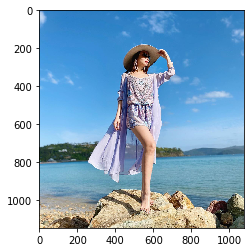

In [13]:
img = mpimg.imread(img_file)

print(img.shape)
#img = img[250:500, 100:300, :]
plt.imshow(img)

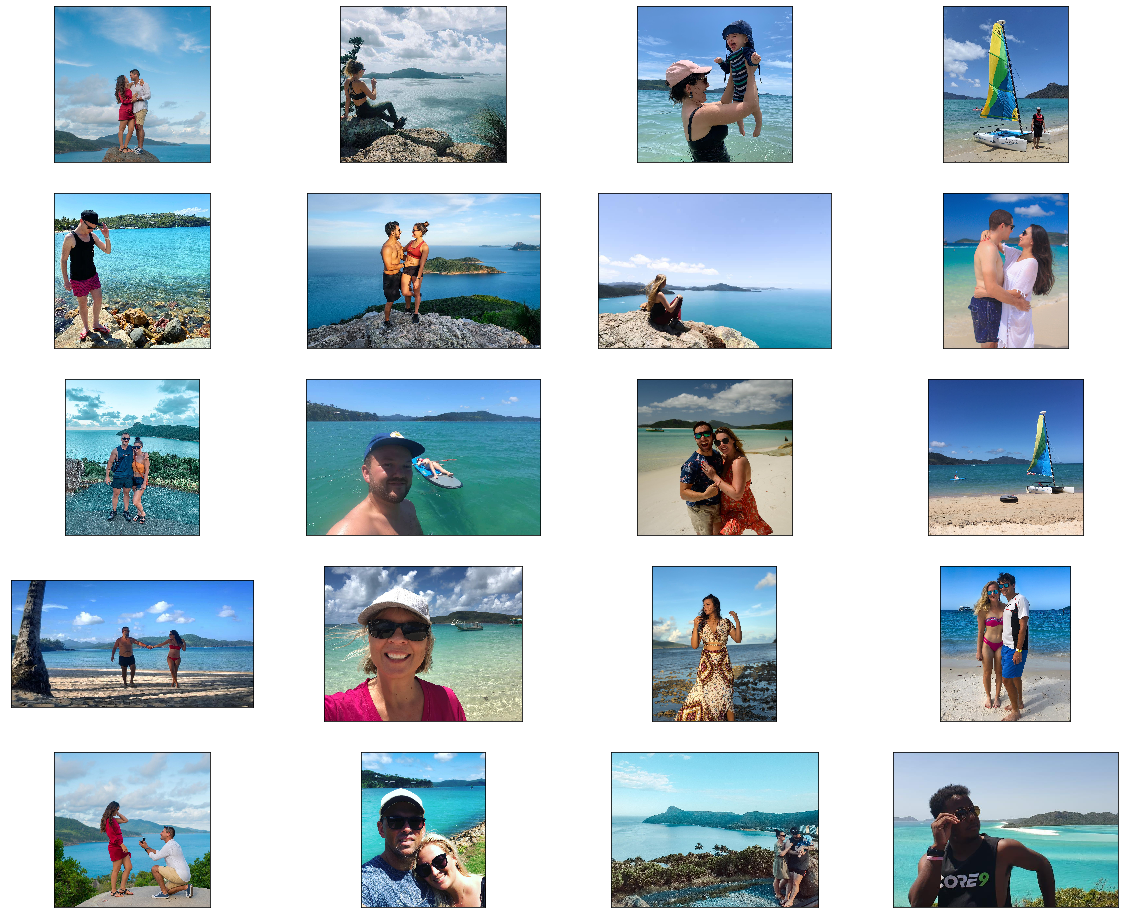

In [14]:
similar_images_df = get_similar_images(img, 20)        
show_similar_images(similar_images_df)
